## Ingest images

In [1]:
from buck.analysis.basics import ingest_images

fpath = "..\\images\\squared\\*.png"
images,ages = ingest_images(fpath)

## Split datasets

In [2]:
from buck.analysis.basics import split_data

Xtr_og, ytr_og, Xval, yval, Xte, yte_onehot, ages, l_map = split_data(images, ages)

## Homogenize data across classes

In [3]:
from buck.analysis.basics import homogenize_data

X_train_pca, y_train_flat, X_test_pca, y_true, label_mapping, num_classes = homogenize_data(Xtr_og, ytr_og, Xte,yte_onehot, l_map)

  Class 0 (Age 1.5): 37 → 134 samples
  Class 1 (Age 2.5): 46 → 134 samples
  Class 2 (Age 3.5): 67 → 134 samples
  Class 3 (Age 4.5): 50 → 134 samples
  Class 4 (Age 5.5): 65 → 134 samples


## Comparison classifier models


Evaluating classifiers...

CLASSIFIER COMPARISON
                  Classifier  Accuracy  F1 Score  Classes Predicted          Predicted Ages
                    AdaBoost  0.309524  0.314032                  5 1.5, 2.5, 3.5, 4.5, 5.5
           Gradient Boosting  0.297619  0.294267                  5 1.5, 2.5, 3.5, 4.5, 5.5
               Decision Tree  0.273810  0.272957                  5 1.5, 2.5, 3.5, 4.5, 5.5
              Neural Network  0.273810  0.271233                  5 1.5, 2.5, 3.5, 4.5, 5.5
                 Extra Trees  0.273810  0.264683                  5 1.5, 2.5, 3.5, 4.5, 5.5
         K-Nearest Neighbors  0.261905  0.260598                  5 1.5, 2.5, 3.5, 4.5, 5.5
               Random Forest  0.238095  0.233154                  5 1.5, 2.5, 3.5, 4.5, 5.5
Linear Discriminant Analysis  0.238095  0.233147                  5 1.5, 2.5, 3.5, 4.5, 5.5
         Logistic Regression  0.226190  0.224094                  5 1.5, 2.5, 3.5, 4.5, 5.5
                 Naive Bayes  

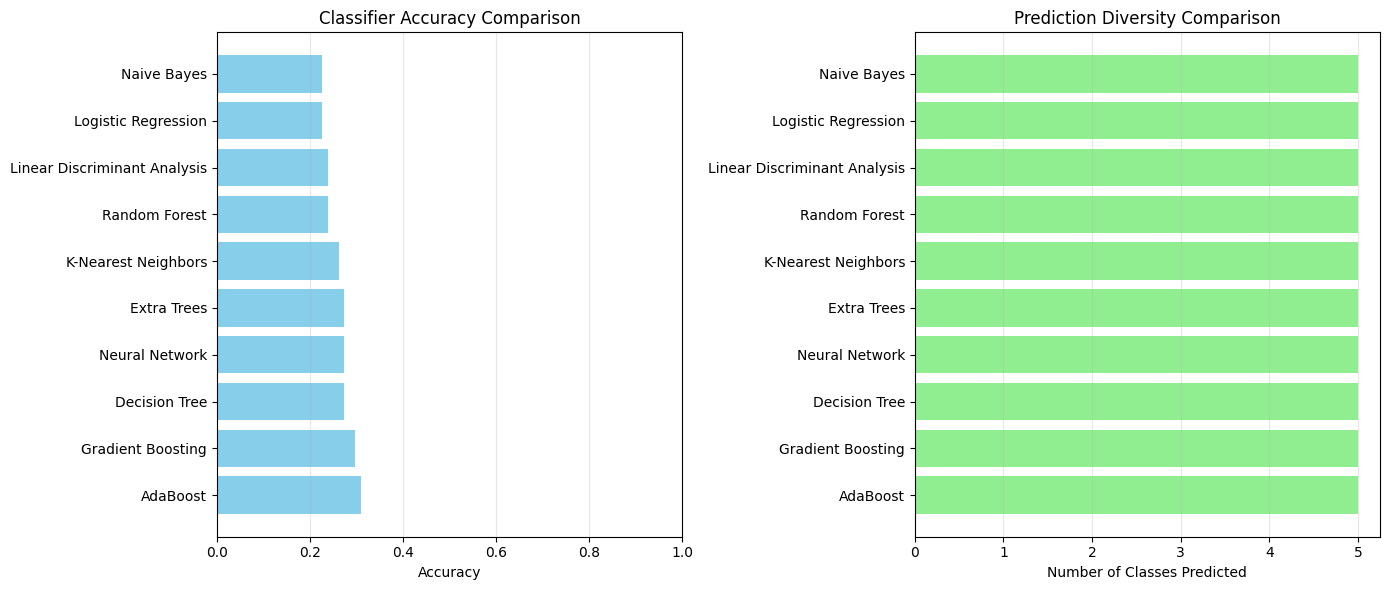


BEST CLASSIFIER
Classifier: AdaBoost
Accuracy: 0.3095
F1 Score: 0.3140
Classes Predicted: 5
Predicted Ages: 1.5, 2.5, 3.5, 4.5, 5.5

Detailed Classification Report for AdaBoost:
              precision    recall  f1-score   support

     Age 1.5       0.25      0.25      0.25        12
     Age 2.5       0.12      0.13      0.13        15
     Age 3.5       0.50      0.43      0.46        21
     Age 4.5       0.26      0.31      0.29        16
     Age 5.5       0.37      0.35      0.36        20

    accuracy                           0.31        84
   macro avg       0.30      0.29      0.30        84
weighted avg       0.32      0.31      0.31        84

1. The best classifier is: AdaBoost
2. This achieved 5 class predictions out of 5 total classes


In [5]:
from buck.analysis.optimize_model import compare_models

compare_models(X_train_pca, y_train_flat, X_test_pca, y_true, num_classes, label_mapping)

In [14]:
# Systematic hyperparameter optimization for RandomForest
print("Systematic RandomForest Hyperparameter Optimization")

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import make_scorer, f1_score, accuracy_score
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define a custom scoring function that prioritizes class diversity
def custom_score(y_true, y_pred):
    """Custom scoring that balances accuracy with prediction diversity"""
    n_classes_predicted = len(np.unique(y_pred))
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    
    # Weight: 40% for diversity, 30% accuracy, 30% F1
    diversity_score = n_classes_predicted / num_classes
    combined_score = (0.4 * diversity_score) + (0.3 * accuracy) + (0.3 * f1)
    
    return combined_score

# Create custom scorer
custom_scorer = make_scorer(custom_score)

# Define comprehensive parameter grid for RandomForest
param_grid_full = {
    'n_estimators': [50, 100, 200, 300, 500],
    'max_depth': [3, 5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['sqrt', 'log2', 0.5, 0.7, None],
    'bootstrap': [True, False],
    'class_weight': ['balanced', 'balanced_subsample', None],
    'criterion': ['gini', 'entropy'],
    'max_samples': [0.5, 0.7, 0.9, None]  # Only used if bootstrap=True
}

# Calculate total combinations
total_combinations = 1
for param, values in param_grid_full.items():
    total_combinations *= len(values)
print(f"Total parameter combinations: {total_combinations:,}")

# Since full grid search might be too expensive, let's use RandomizedSearchCV first
print("\nPhase 1: Random Search to find promising regions")

# Random search parameters
random_param_distributions = {
    'n_estimators': [50, 100, 200, 300, 400, 500, 700, 1000],
    'max_depth': list(range(3, 21)) + [None],
    'min_samples_split': list(range(2, 21)),
    'min_samples_leaf': list(range(1, 11)),
    'max_features': ['sqrt', 'log2'] + list(np.arange(0.3, 0.9, 0.1)),
    'bootstrap': [True, False],
    'class_weight': ['balanced', 'balanced_subsample', None],
    'criterion': ['gini', 'entropy'],
    'max_samples': list(np.arange(0.5, 1.0, 0.1)) + [None]
}

# Phase 1: Random Search
start_time = time.time()

# Use the PCA-transformed data from your previous code
X_train = X_train_pca
X_test_final = X_test_pca
y_train = y_train_flat

rf_random = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=random_param_distributions,
    n_iter=200,  # Number of random combinations to try
    cv=3,  # 3-fold cross-validation
    scoring=custom_scorer,
    n_jobs=-1,  # Use all cores
    verbose=2,
    random_state=42
)

rf_random.fit(X_train, y_train)

print(f"\nRandom Search completed in {time.time() - start_time:.2f} seconds")
print(f"Best score: {rf_random.best_score_:.4f}")
print(f"Best parameters: {rf_random.best_params_}")

# Phase 2: Focused Grid Search around best parameters
print("\nPhase 2: Grid Search around best parameters")

# Create a focused grid around the best parameters found
best_params = rf_random.best_params_
focused_param_grid = {}

# For each parameter, search around the best value
for param, best_value in best_params.items():
    if param == 'n_estimators':
        values = [max(50, best_value - 100), best_value - 50, best_value, 
                 best_value + 50, best_value + 100]
        focused_param_grid[param] = sorted(list(set(values)))
    
    elif param == 'max_depth':
        if best_value is None:
            focused_param_grid[param] = [15, 20, 25, 30, None]
        else:
            values = [max(3, best_value - 2), best_value - 1, best_value, 
                     best_value + 1, best_value + 2]
            focused_param_grid[param] = sorted(list(set(values)))
    
    elif param in ['min_samples_split', 'min_samples_leaf']:
        values = [max(1, best_value - 2), best_value - 1, best_value, 
                 best_value + 1, best_value + 2]
        focused_param_grid[param] = sorted(list(set(values)))
    
    elif param == 'max_features':
        if isinstance(best_value, str):
            focused_param_grid[param] = ['sqrt', 'log2', 0.5, 0.7]
        else:
            values = [max(0.3, best_value - 0.1), best_value, min(0.9, best_value + 0.1)]
            focused_param_grid[param] = values
    
    elif param == 'bootstrap':
        focused_param_grid[param] = [True, False]
    
    elif param == 'class_weight':
        focused_param_grid[param] = ['balanced', 'balanced_subsample', None]
    
    elif param == 'criterion':
        focused_param_grid[param] = ['gini', 'entropy']
    
    elif param == 'max_samples':
        if best_value is None:
            focused_param_grid[param] = [0.7, 0.8, 0.9, None]
        else:
            values = [max(0.5, best_value - 0.1), best_value, min(0.95, best_value + 0.1)]
            focused_param_grid[param] = values

print("\nFocused parameter grid:")
for param, values in focused_param_grid.items():
    print(f"{param}: {values}")

# Focused grid search
start_time = time.time()

rf_grid = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=focused_param_grid,
    cv=3,
    scoring=custom_scorer,
    n_jobs=-1,
    verbose=2
)

rf_grid.fit(X_train, y_train)

print(f"\nGrid Search completed in {time.time() - start_time:.2f} seconds")
print(f"Best score: {rf_grid.best_score_:.4f}")
print(f"Best parameters: {rf_grid.best_params_}")

# Phase 3: Final evaluation with best model
print("\nPhase 3: Final evaluation with optimized model")

best_rf = rf_grid.best_estimator_

# Evaluate on test set
y_pred = best_rf.predict(X_test_final)

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
n_classes_predicted = len(np.unique(y_pred))

print(f"\nOptimized RandomForest Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Classes predicted: {n_classes_predicted} out of {num_classes}")
print(f"Predicted classes: {[reverse_mapping[p] for p in np.unique(y_pred)]}")

# Confusion matrix
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=[f"{reverse_mapping[i]} yrs" for i in np.unique(np.concatenate([y_true, y_pred]))],
           yticklabels=[f"{reverse_mapping[i]} yrs" for i in np.unique(np.concatenate([y_true, y_pred]))])
plt.xlabel('Predicted Age')
plt.ylabel('True Age')
plt.title('Optimized RandomForest Confusion Matrix')
plt.tight_layout()
plt.show()

# Feature importance analysis
feature_importances = best_rf.feature_importances_
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances)), feature_importances)
plt.xlabel('PCA Component')
plt.ylabel('Importance')
plt.title('Feature Importances in Optimized RandomForest')
plt.show()

# Create a detailed comparison with default RandomForest
print("\nComparison with Default RandomForest:")

default_rf = RandomForestClassifier(random_state=42)
default_rf.fit(X_train, y_train)
y_pred_default = default_rf.predict(X_test_final)

default_accuracy = accuracy_score(y_true, y_pred_default)
default_f1 = f1_score(y_true, y_pred_default, average='weighted', zero_division=0)
default_classes = len(np.unique(y_pred_default))

comparison_df = pd.DataFrame({
    'Model': ['Default RF', 'Optimized RF'],
    'Accuracy': [default_accuracy, accuracy],
    'F1 Score': [default_f1, f1],
    'Classes Predicted': [default_classes, n_classes_predicted],
    'Best Parameters': [str(default_rf.get_params()), str(best_rf.get_params())]
})

print(comparison_df.to_string(index=False))

# Save the best parameters for future use
best_params_df = pd.DataFrame([rf_grid.best_params_])
best_params_df.to_csv('optimized_rf_parameters.csv', index=False)
print("\nBest parameters saved to 'optimized_rf_parameters.csv'")

# Optional: Perform learning curves analysis
from sklearn.model_selection import learning_curve

print("\nGenerating learning curves...")

train_sizes, train_scores, val_scores = learning_curve(
    best_rf, X_train, y_train, cv=3, 
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring=custom_scorer, n_jobs=-1
)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Training score')
plt.plot(train_sizes, np.mean(val_scores, axis=1), 'o-', label='Validation score')
plt.xlabel('Training Set Size')
plt.ylabel('Score')
plt.title('Learning Curves for Optimized RandomForest')
plt.legend()
plt.grid(True)
plt.show()

# Print final recommendations
print("\n" + "="*50)
print("HYPERPARAMETER OPTIMIZATION COMPLETE")
print("="*50)
print(f"Best parameters found:")
for param, value in rf_grid.best_params_.items():
    print(f"  {param}: {value}")
print(f"\nPerformance improvement:")
print(f"  Default accuracy: {default_accuracy:.4f} → Optimized: {accuracy:.4f}")
print(f"  Default classes: {default_classes} → Optimized: {n_classes_predicted}")
print(f"\nOptimization tips:")
print("1. If still predicting too few classes, adjust custom_score weights")
print("2. Consider ensemble methods combining multiple optimized models")
print("3. Try different cross-validation strategies (e.g., StratifiedKFold)")
print("4. Collect more training data for underrepresented classes")

TypeError: unhashable type: 'numpy.ndarray'

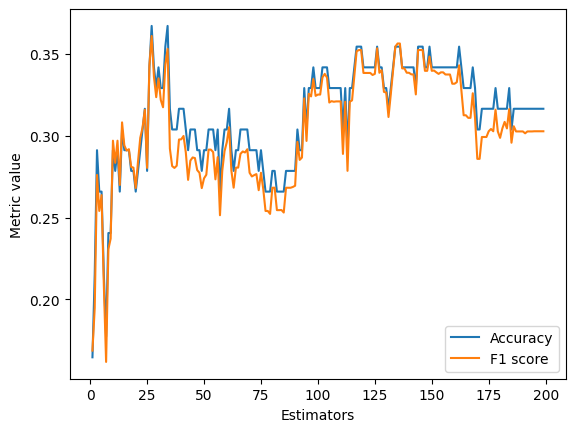

In [5]:
ac_vec = []
f1_vec = []
x = np.arange(1,200)
for n in x:
    #classifier = RandomForestClassifier(n_estimators=n,
    #                                    max_depth=5,
    #                                    class_weight='balanced',
    #                                    random_state=42)

    classifier = RandomForestClassifier(n_estimators=n,
                                        max_depth=5,
                                        criterion='gini',
                                        random_state=42,
                                        class_weight='balanced',
                                        min_samples_split=2,
                                        min_samples_leaf=1,
                                        min_weight_fraction_leaf=0.0,
                                        max_features='sqrt',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        bootstrap=True,
                                        oob_score=False,
                                        n_jobs=None,
                                        verbose=0,
                                        warm_start=False,
                                        ccp_alpha=0.0,
                                        max_samples=None,
                                        monotonic_cst=None)
    
    
    # Train the classifier
    classifier.fit(X_train_pca, y_train_flat)
    # Make predictions
    y_pred = classifier.predict(X_test_pca)
    # Store predictions
    all_predictions[name] = y_pred
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    # Store results
    ac_vec.append(accuracy)
    f1_vec.append(f1)
    
    # Track predictions by class
    unique_preds = set(y_pred)
    class_predictions[name] = unique_preds
    
plt.figure()
plt.xlabel('Estimators')
plt.ylabel('Metric value')
plt.plot(x,ac_vec,label='Accuracy')
plt.plot(x,f1_vec,label='F1 score')
plt.legend()
plt.show()

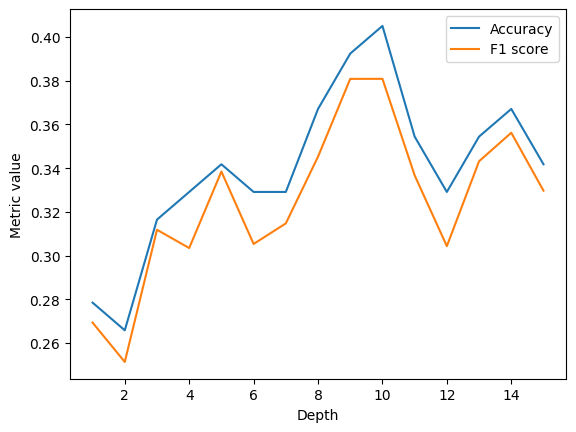

In [6]:
ac_vec = []
f1_vec = []
x = np.arange(1,16)
for n in x:
    classifier = RandomForestClassifier(n_estimators=140,
                                        max_depth=n,
                                        criterion='gini',
                                        random_state=42,
                                        class_weight='balanced',
                                        min_samples_split=2,
                                        min_samples_leaf=1,
                                        min_weight_fraction_leaf=0.0,
                                        max_features='sqrt',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        bootstrap=True,
                                        oob_score=False,
                                        n_jobs=None,
                                        verbose=0,
                                        warm_start=False,
                                        ccp_alpha=0.0,
                                        max_samples=None,
                                        monotonic_cst=None)
    # Train the classifier
    classifier.fit(X_train_pca, y_train_flat)
    # Make predictions
    y_pred = classifier.predict(X_test_pca)
    # Store predictions
    all_predictions[name] = y_pred
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    # Store results
    ac_vec.append(accuracy)
    f1_vec.append(f1)
    
    # Track predictions by class
    unique_preds = set(y_pred)
    class_predictions[name] = unique_preds
    
plt.figure()
plt.xlabel('Depth')
plt.ylabel('Metric value')
plt.plot(x,ac_vec,label='Accuracy')
plt.plot(x,f1_vec,label='F1 score')
plt.legend()
plt.show()

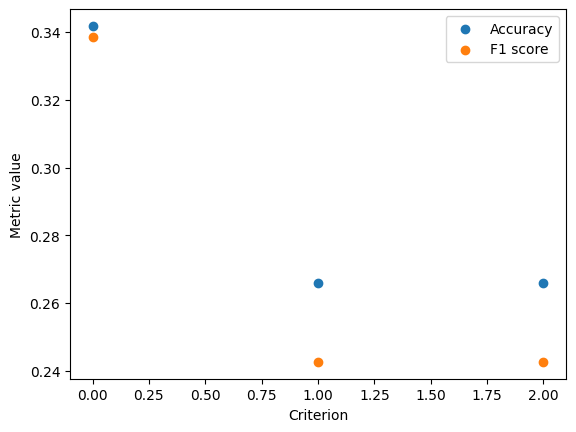

In [7]:
ac_vec = []
f1_vec = []
var = ['gini', 'entropy', 'log_loss']
for x in var:
    classifier = RandomForestClassifier(n_estimators=140,
                                        max_depth=5,
                                        criterion=x,
                                        random_state=42,
                                        class_weight='balanced',
                                        min_samples_split=2,
                                        min_samples_leaf=1,
                                        min_weight_fraction_leaf=0.0,
                                        max_features='sqrt',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        bootstrap=True,
                                        oob_score=False,
                                        n_jobs=None,
                                        verbose=0,
                                        warm_start=False,
                                        ccp_alpha=0.0,
                                        max_samples=None,
                                        monotonic_cst=None)
    
    # Train the classifier
    classifier.fit(X_train_pca, y_train_flat)
    # Make predictions
    y_pred = classifier.predict(X_test_pca)
    # Store predictions
    all_predictions[name] = y_pred
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    # Store results
    ac_vec.append(accuracy)
    f1_vec.append(f1)
    
    # Track predictions by class
    unique_preds = set(y_pred)
    class_predictions[name] = unique_preds
    
x = np.arange(len(var))
plt.figure()
plt.xlabel('Criterion')
plt.ylabel('Metric value')
plt.scatter(x,ac_vec,label='Accuracy')
plt.scatter(x,f1_vec,label='F1 score')
plt.legend()
plt.show()

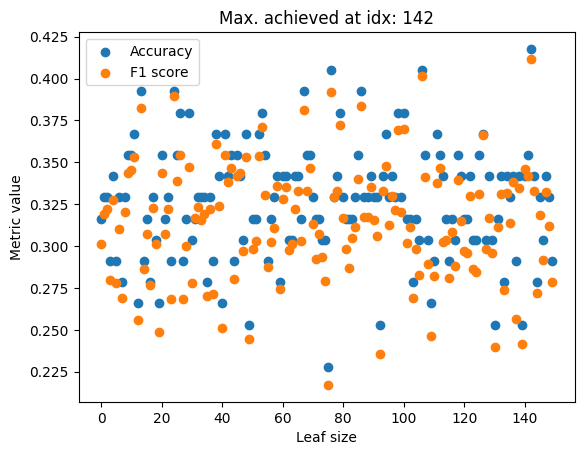

In [8]:
ac_vec = []
f1_vec = []
max_acc = -np.inf
max_idx = -1
l_size = np.arange(150)
for l in l_size:
    # Define classifiers to test
    classifier = RandomForestClassifier(n_estimators=140,
                                        max_depth=5,
                                        criterion='gini',
                                        random_state=l,
                                        class_weight='balanced',
                                        min_samples_split=2,
                                        min_samples_leaf=1,
                                        min_weight_fraction_leaf=0.0,
                                        max_features='sqrt',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        bootstrap=True,
                                        oob_score=False,
                                        n_jobs=None,
                                        verbose=0,
                                        warm_start=False,
                                        ccp_alpha=0.0,
                                        max_samples=None,
                                        monotonic_cst=None)
    # Train the classifier
    classifier.fit(X_train_pca, y_train_flat)
    # Make predictions
    y_pred = classifier.predict(X_test_pca)
    # Store predictions
    all_predictions[name] = y_pred
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    # Return index
    if np.max(accuracy) > max_acc:
        max_idx = l
        max_acc = accuracy
    # Store results
    ac_vec.append(accuracy)
    f1_vec.append(f1)
    
    # Track predictions by class
    unique_preds = set(y_pred)
    class_predictions[name] = unique_preds
    
x = np.arange(len(l_size))
title = 'Max. achieved at idx: ' + str(max_idx)
plt.figure()
plt.xlabel('Leaf size')
plt.ylabel('Metric value')
plt.scatter(x,ac_vec,label='Accuracy')
plt.scatter(x,f1_vec,label='F1 score')
plt.legend()
plt.title(title)
plt.show()

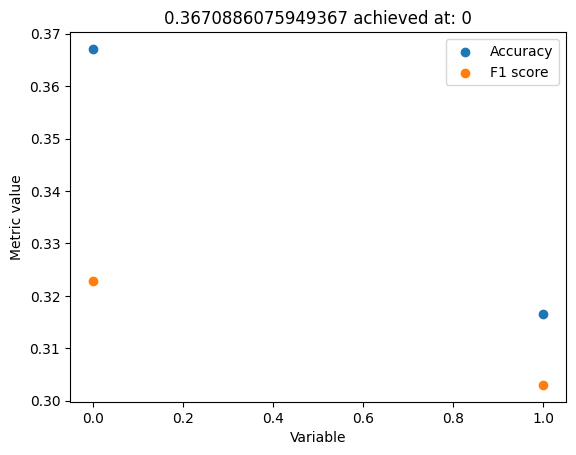

In [9]:
ac_vec = []
f1_vec = []
max_acc = -np.inf
max_idx = -1
l_size = np.arange(2)
for l in l_size:
    cwl = [None,'balanced','balanced_subsample']
    cw = cwl[l]
    # Define classifiers to test
    classifier = RandomForestClassifier(n_estimators=140,
                                        max_depth=5,
                                        criterion='gini',
                                        random_state=66,
                                        class_weight=cw,
                                        min_samples_split=2,
                                        min_samples_leaf=1,
                                        min_weight_fraction_leaf=0.0,
                                        max_features='sqrt',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        bootstrap=True,
                                        oob_score=False,
                                        n_jobs=None,
                                        verbose=0,
                                        warm_start=False,
                                        ccp_alpha=0.0,
                                        max_samples=None,
                                        monotonic_cst=None)
    # Train the classifier
    classifier.fit(X_train_pca, y_train_flat)
    # Make predictions
    y_pred = classifier.predict(X_test_pca)
    # Store predictions
    all_predictions[name] = y_pred
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    # Return index
    if np.max(accuracy) > max_acc:
        max_idx = l
        max_acc = accuracy
    # Store results
    ac_vec.append(accuracy)
    f1_vec.append(f1)
    
    # Track predictions by class
    unique_preds = set(y_pred)
    class_predictions[name] = unique_preds
    
x = np.arange(len(l_size))
title = str(max_acc) + ' achieved at: ' + str(max_idx)
plt.figure()
plt.xlabel('Variable')
plt.ylabel('Metric value')
plt.scatter(x,ac_vec,label='Accuracy')
plt.scatter(x,f1_vec,label='F1 score')
plt.legend()
plt.title(title)
plt.show()

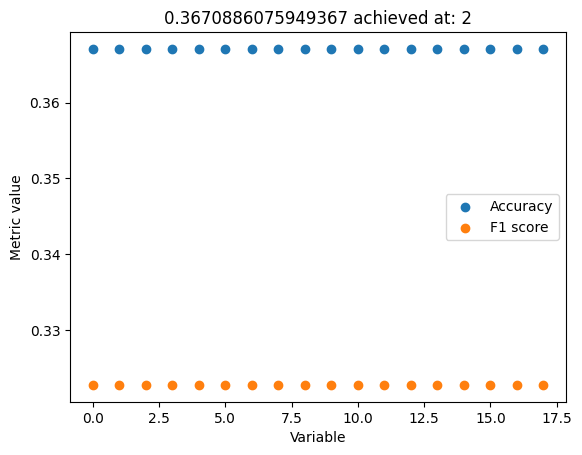

In [10]:
ac_vec = []
f1_vec = []
max_acc = -np.inf
max_idx = -1
l_size = np.arange(2,20,1)
for l in l_size:
    # Define classifiers to test
    classifier = RandomForestClassifier(n_estimators=140,
                                        max_depth=5,
                                        criterion='gini',
                                        random_state=66,
                                        class_weight=None,
                                        min_samples_split=2,
                                        min_samples_leaf=1,
                                        min_weight_fraction_leaf=0.0,
                                        max_features='sqrt',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        bootstrap=True,
                                        oob_score=False,
                                        n_jobs=None,
                                        verbose=0,
                                        warm_start=False,
                                        ccp_alpha=0.0,
                                        max_samples=None,
                                        monotonic_cst=None)
    # Train the classifier
    classifier.fit(X_train_pca, y_train_flat)
    # Make predictions
    y_pred = classifier.predict(X_test_pca)
    # Store predictions
    all_predictions[name] = y_pred
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    # Return index
    if np.max(accuracy) > max_acc:
        max_idx = l
        max_acc = accuracy
    # Store results
    ac_vec.append(accuracy)
    f1_vec.append(f1)
    
    # Track predictions by class
    unique_preds = set(y_pred)
    class_predictions[name] = unique_preds
    
x = np.arange(len(l_size))
title = str(max_acc) + ' achieved at: ' + str(max_idx)
plt.figure()
plt.xlabel('Variable')
plt.ylabel('Metric value')
plt.scatter(x,ac_vec,label='Accuracy')
plt.scatter(x,f1_vec,label='F1 score')
plt.legend()
plt.title(title)
plt.show()

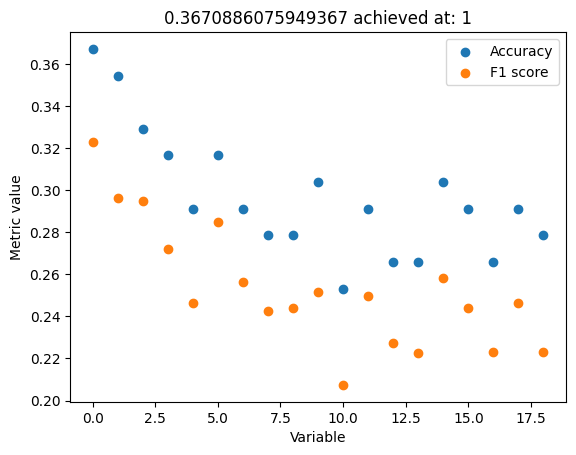

In [11]:
ac_vec = []
f1_vec = []
max_acc = -np.inf
max_idx = -1
l_size = np.arange(1,20,1)
for l in l_size:
    # Define classifiers to test
    classifier = RandomForestClassifier(n_estimators=140,
                                        max_depth=5,
                                        criterion='gini',
                                        random_state=66,
                                        class_weight=None,
                                        min_samples_split=2,
                                        min_samples_leaf=int(l),
                                        min_weight_fraction_leaf=0.0,
                                        max_features='sqrt',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        bootstrap=True,
                                        oob_score=False,
                                        n_jobs=None,
                                        verbose=0,
                                        warm_start=False,
                                        ccp_alpha=0.0,
                                        max_samples=None,
                                        monotonic_cst=None)
    # Train the classifier
    classifier.fit(X_train_pca, y_train_flat)
    # Make predictions
    y_pred = classifier.predict(X_test_pca)
    # Store predictions
    all_predictions[name] = y_pred
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    # Return index
    if np.max(accuracy) > max_acc:
        max_idx = l
        max_acc = accuracy
    # Store results
    ac_vec.append(accuracy)
    f1_vec.append(f1)
    
    # Track predictions by class
    unique_preds = set(y_pred)
    class_predictions[name] = unique_preds
    
x = np.arange(len(l_size))
title = str(max_acc) + ' achieved at: ' + str(max_idx)
plt.figure()
plt.xlabel('Variable')
plt.ylabel('Metric value')
plt.scatter(x,ac_vec,label='Accuracy')
plt.scatter(x,f1_vec,label='F1 score')
plt.legend()
plt.title(title)
plt.show()

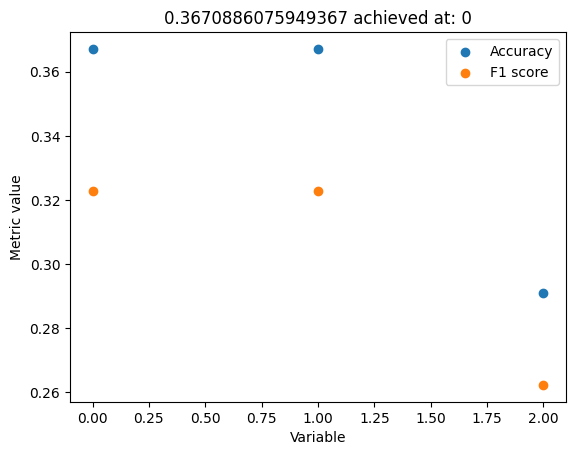

In [12]:
ac_vec = []
f1_vec = []
max_acc = -np.inf
max_idx = -1
myarr = ['sqrt', 'log2', None]
l_size = np.arange(len(myarr))
for l in l_size:
    mx = myarr[l]
    # Define classifiers to test
    classifier = RandomForestClassifier(n_estimators=140,
                                        max_depth=5,
                                        criterion='gini',
                                        random_state=66,
                                        class_weight=None,
                                        min_samples_split=2,
                                        min_samples_leaf=1,
                                        min_weight_fraction_leaf=0.0,
                                        max_features=mx,
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        bootstrap=True,
                                        oob_score=False,
                                        n_jobs=None,
                                        verbose=0,
                                        warm_start=False,
                                        ccp_alpha=0.0,
                                        max_samples=None,
                                        monotonic_cst=None)
    # Train the classifier
    classifier.fit(X_train_pca, y_train_flat)
    # Make predictions
    y_pred = classifier.predict(X_test_pca)
    # Store predictions
    all_predictions[name] = y_pred
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    # Return index
    if np.max(accuracy) > max_acc:
        max_idx = l
        max_acc = accuracy
    # Store results
    ac_vec.append(accuracy)
    f1_vec.append(f1)
    
    # Track predictions by class
    unique_preds = set(y_pred)
    class_predictions[name] = unique_preds
    
x = np.arange(len(l_size))
title = str(max_acc) + ' achieved at: ' + str(max_idx)
plt.figure()
plt.xlabel('Variable')
plt.ylabel('Metric value')
plt.scatter(x,ac_vec,label='Accuracy')
plt.scatter(x,f1_vec,label='F1 score')
plt.legend()
plt.title(title)
plt.show()

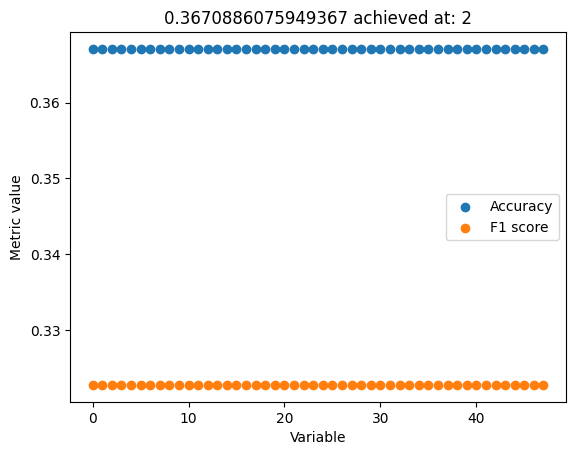

In [13]:
ac_vec = []
f1_vec = []
max_acc = -np.inf
max_idx = -1
l_size = np.arange(2,50,1)
for l in l_size:
    # Define classifiers to test
    classifier = RandomForestClassifier(n_estimators=140,
                                        max_depth=5,
                                        criterion='gini',
                                        random_state=66,
                                        class_weight=None,
                                        min_samples_split=2,
                                        min_samples_leaf=1,
                                        min_weight_fraction_leaf=0.0,
                                        max_features='sqrt',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        bootstrap=True,
                                        oob_score=False,
                                        n_jobs=None,
                                        verbose=0,
                                        warm_start=False,
                                        ccp_alpha=0.0,
                                        max_samples=None,
                                        monotonic_cst=None)
    # Train the classifier
    classifier.fit(X_train_pca, y_train_flat)
    # Make predictions
    y_pred = classifier.predict(X_test_pca)
    # Store predictions
    all_predictions[name] = y_pred
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    # Return index
    if np.max(accuracy) > max_acc:
        max_idx = l
        max_acc = accuracy
    # Store results
    ac_vec.append(accuracy)
    f1_vec.append(f1)
    
    # Track predictions by class
    unique_preds = set(y_pred)
    class_predictions[name] = unique_preds
    
x = np.arange(len(l_size))
title = str(max_acc) + ' achieved at: ' + str(max_idx)
plt.figure()
plt.xlabel('Variable')
plt.ylabel('Metric value')
plt.scatter(x,ac_vec,label='Accuracy')
plt.scatter(x,f1_vec,label='F1 score')
plt.legend()
plt.title(title)
plt.show()

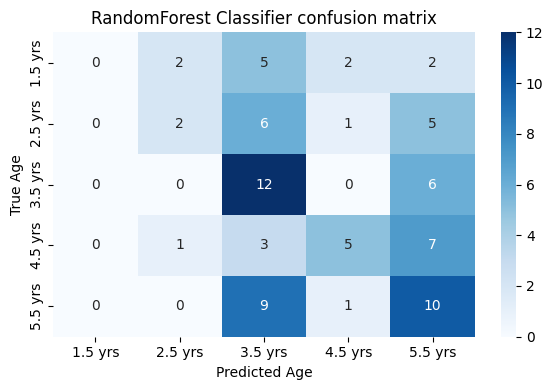

Accuracy: 36.71%


In [14]:
# Define classifiers to test
classifier = RandomForestClassifier(n_estimators=140,
                                    max_depth=5,
                                    criterion='gini',
                                    random_state=66,
                                    class_weight=None,
                                    min_samples_split=2,
                                    min_samples_leaf=1,
                                    min_weight_fraction_leaf=0.0,
                                    max_features='sqrt',
                                    max_leaf_nodes=None,
                                    min_impurity_decrease=0.0,
                                    bootstrap=True,
                                    oob_score=False,
                                    n_jobs=None,
                                    verbose=0,
                                    warm_start=False,
                                    ccp_alpha=0.0,
                                    max_samples=None,
                                    monotonic_cst=None)
# Train the classifier
classifier.fit(X_train_pca, y_train_flat)

# Make predictions
y_pred = classifier.predict(X_test_pca)

# Store predictions
all_predictions[name] = y_pred

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

# Track predictions by class
unique_preds = set(y_pred)
class_predictions[name] = unique_preds

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=[f"{reverse_mapping[i]} yrs" for i in np.unique(np.concatenate([y_true, y_pred]))],
           yticklabels=[f"{reverse_mapping[i]} yrs" for i in np.unique(np.concatenate([y_true, y_pred]))])
plt.xlabel('Predicted Age')
plt.ylabel('True Age')
plt.title(f'RandomForest Classifier confusion matrix')
plt.tight_layout()
plt.show()

print(f"Accuracy: {accuracy*100:.2f}%")